In [22]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
data = pd.read_csv('data.csv')

## County Selection

In [24]:
data['entity'] = data['state'] + '-' + data['county']

In [25]:
# compute the incremental case as response
def incremental(df):
    df['incremental_cases'] = df['cases'].diff().fillna(df['cases'])
    return df
data = data.groupby('entity').apply(lambda x: incremental(x))

print(data.groupby('entity').count().loc[:, ['date']].sort_values(
    by = 'date', ascending = False).reset_index().rename(columns = {'date':'num_date'}).head(13))

# find out counties with case data issue
data_prob = list(data[data['incremental_cases'] < 0].entity.unique())

# drop counties with data issue
data = data[-data['entity'].isin(data_prob)]

print(data.groupby('entity').count().loc[:, ['date']].sort_values(
    by = 'date', ascending = False).reset_index().rename(columns = {'date':'num_date'}).head(13))


                      entity  num_date
0       Washington-Snohomish       319
1              Illinois-Cook       316
2          California-Orange       315
3     California-Los Angeles       314
4           Arizona-Maricopa       314
5     California-Santa Clara       309
6      Massachusetts-Suffolk       308
7   California-San Francisco       307
8             Wisconsin-Dane       304
9       California-San Diego       299
10               Texas-Bexar       297
11          Nebraska-Douglas       292
12       California-Humboldt       289
                    entity  num_date
0            Illinois-Cook       316
1        California-Orange       315
2   California-Los Angeles       314
3   California-Santa Clara       309
4     California-San Diego       299
5         Nebraska-Douglas       292
6    California-Sacramento       288
7        California-Solano       285
8       Washington-Spokane       285
9           Utah-Salt Lake       284
10       California-Sonoma       283
11        

In [28]:
# number of rows / reported date for each county
county_date = data.groupby('entity').count().loc[:, ['date']].sort_values(
    by = 'date', ascending = False).reset_index().rename(columns = {'date':'num_date'})

# number of days between a county's first and last report of cases
report_date = data.groupby('entity')['date'].min().reset_index().rename(
    columns = {'date':'start'}).merge(data.groupby('entity')['date'].max().reset_index().rename(
    columns = {'date':'end'}), on = 'entity')

report_date['start'] = pd.to_datetime(report_date['start'], format='%Y-%m-%d')
report_date['end'] = pd.to_datetime(report_date['end'], format='%Y-%m-%d')

report_date['days'] = (report_date['end'] - report_date['start']).dt.days + 1

# identify any potential gaps in reporting frequency
    # in other words, whether a county missed reporting for certain dates

freq_df = report_date.loc[:, ['entity', 'days']].merge(county_date, on = 'entity')
freq_df['frequency'] = freq_df['num_date'] / freq_df['days']

print(freq_df.sort_values(by = 'frequency').head(10))

                      entity  days  num_date  frequency
76               Idaho-Clark   139       133   0.956835
0             Alabama-Blount   255       255   1.000000
287      Pennsylvania-Mercer   258       258   1.000000
286     Pennsylvania-Luzerne   265       265   1.000000
285     Pennsylvania-Lebanon   261       261   1.000000
284   Pennsylvania-Lancaster   261       261   1.000000
283  Pennsylvania-Lackawanna   262       262   1.000000
282      Pennsylvania-Greene   255       255   1.000000
281    Pennsylvania-Delaware   274       274   1.000000
280     Pennsylvania-Dauphin   258       258   1.000000


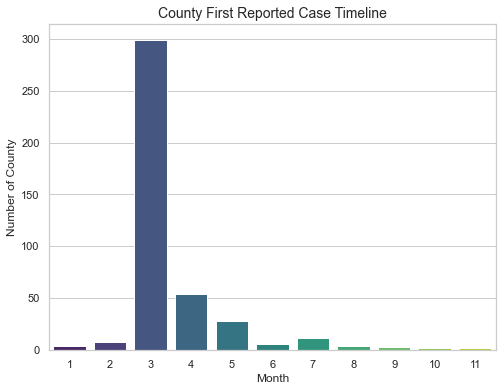

In [29]:
# visualization on the timeline when counties have their first COVID-19 case
t = data.groupby('entity')['date'].min().reset_index().rename(
    columns = {'date':'start'})

t['start'] = pd.to_datetime(t['start'], format='%Y-%m-%d')

t['startmonth'] = t['start'].apply(lambda x: x.month)

df = t.groupby(['startmonth']).count().iloc[:, :1].reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=df.columns[0], y=df.columns[1], data=df, palette="viridis")
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Number of County', fontsize = 12)
plt.title('County First Reported Case Timeline', fontsize = 14)
plt.show()

### Select Top 12 Counties for Model Development

In [30]:
data = data.drop(columns = ['county', 'state'])
entity_date = data.groupby('entity').count().loc[:, ['date']].sort_values(
    by = 'date', ascending = False).reset_index().rename(columns = {'date':'num_date'}).head(13)

# Douglas in Nebraska is excluded because Nebraska never initiated stay-at-home order
entity_date = entity_date[entity_date['entity'] != 'Nebraska-Douglas']
data.loc[data['entity'].isin(entity_date.entity.to_list())].to_csv('county_data.csv')

## Feature Selection

In [46]:
data = pd.read_csv('county_data.csv').iloc[:, 1:]
# first 57 features (included incremental_cases and entity for identification purposes)
data = data.iloc[:, [-1] + [-2] + list(range(57))]
data.columns

Index(['incremental_cases', 'entity', 'date', 'fips', 'cases', 'deaths',
       'stay_at_home_announced', 'stay_at_home_effective', 'lat', 'lon',
       'total_population', 'area_sqmi', 'population_density_per_sqmi',
       'num_deaths', 'years_of_potential_life_lost_rate',
       'percent_fair_or_poor_health',
       'average_number_of_physically_unhealthy_days',
       'average_number_of_mentally_unhealthy_days', 'percent_low_birthweight',
       'percent_smokers', 'percent_adults_with_obesity',
       'food_environment_index', 'percent_physically_inactive',
       'percent_with_access_to_exercise_opportunities',
       'percent_excessive_drinking', 'num_alcohol_impaired_driving_deaths',
       'num_driving_deaths', 'percent_driving_deaths_with_alcohol_involvement',
       'num_chlamydia_cases', 'chlamydia_rate', 'teen_birth_rate',
       'num_uninsured', 'percent_uninsured', 'num_primary_care_physicians',
       'primary_care_physicians_rate', 'num_dentists', 'dentist_rate',
       

In [47]:
# Step 1: remove features based on domain knowledge / common sense / redundency
    # fips: unique identifier of county (redundant with 'entity')
    # deaths: COVID-19 deaths (can't act as a predictor for COVID cases as it provides overly relevant info)
    # total_population vs. population: not sure about the difference but will keep both for now

data = data.drop(columns = ['fips', 'deaths', 'cases'])

In [48]:
# Step 2: remove constant or quasi constant features

def quasi_constant(df, threshold):
    quasi_constant_cols = []
    for col in df.columns:
        dominant_freq = df[col].value_counts(normalize=True).values[0]
        if dominant_freq >= threshold:
            quasi_constant_cols.append(col)
    return quasi_constant_cols

quasi_constant(data, threshold=0.95)

[]

In [49]:
# Step 3: missing value check
data.isna().sum()

incremental_cases                                  0
entity                                             0
date                                               0
stay_at_home_announced                             0
stay_at_home_effective                             0
lat                                                0
lon                                                0
total_population                                   0
area_sqmi                                          0
population_density_per_sqmi                        0
num_deaths                                         0
years_of_potential_life_lost_rate                  0
percent_fair_or_poor_health                        0
average_number_of_physically_unhealthy_days        0
average_number_of_mentally_unhealthy_days          0
percent_low_birthweight                            0
percent_smokers                                    0
percent_adults_with_obesity                        0
food_environment_index                        

In [50]:
# Step 4: correlation analysis

data.corr()['incremental_cases']

incremental_cases                                  1.000000
lat                                               -0.109130
lon                                                0.341288
total_population                                   0.564404
area_sqmi                                          0.293254
population_density_per_sqmi                        0.377503
num_deaths                                         0.582624
years_of_potential_life_lost_rate                  0.119723
percent_fair_or_poor_health                        0.418826
average_number_of_physically_unhealthy_days        0.104057
average_number_of_mentally_unhealthy_days         -0.029682
percent_low_birthweight                            0.331033
percent_smokers                                    0.152817
percent_adults_with_obesity                       -0.012846
food_environment_index                             0.041224
percent_physically_inactive                        0.037210
percent_with_access_to_exercise_opportun